<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/notebooks-readme/covid-19-lockdowns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
!pip install --quiet poetry  # Fixes https://github.com/python-poetry/poetry/issues/532
!pip install --quiet git+https://github.com/oughtinc/ergo.git@8c59f21b294436b5b895c6c70d8e2b6174e8fbcb
!pip install --quiet pendulum seaborn

     |████████████████████████████████| 225kB 2.8MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
     |████████████████████████████████| 112kB 51.0MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 2.7MB 47.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 153kB 2.7MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 522kB 47.2MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 29.3MB 109kB/s 
     |████████████████████████████████| 491kB 47.3MB/s 
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.


In [0]:
import requests
import torch
import io
import zipfile
import os
import ergo
import pendulum
import requests
import scipy.stats

import seaborn as sns 
import pandas as pd
import numpy as np

from types import SimpleNamespace
from typing import List
from pendulum import Date, Duration
from matplotlib import pyplot as plt
from ergo import logistic

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Log into a Metaculus account

If running in a collab notebook, please enter your Metaculus credentials here 

In [0]:
def is_local():
  try:
    %env USER
    return True
  except:
    return False

metaculus_api = "pandemic"

if is_local():
  from dotenv import load_dotenv
  load_dotenv() 
  metaculus = ergo.Metaculus(username=os.getenv("METACULUS_USERNAME"), password=os.getenv("METACULUS_PASSWORD"), api_domain=metaculus_api)
else: 
  try:    
    metaculus = ergo.Metaculus(username="", password="", api_domain=metaculus_api)  
  except: 
    print(f'WARNING, You will need to enter your metaculus credentials in this cell')


WARNING, You will need to enter your metaculus credentials in this cell


# Questions

Here are the question we want to forecast:

In [0]:

question_ids = [
  3935,
  3948,
  3952,
  3951,
  3946,
  3942,
  3941,
  3939,
  3937,
  3936,
  3938,
  3940 
]
question_names = [
    "The United Kingdom",
    "France",
    "The State of New York",
    "New Zealand",
    "India",
    "South Africa",
    "Poland",
    "The State of California",
    "Italy",
    "Spain",
    "São Paulo (Brazil)",
    "The Province of Punjab (Pakistan)"
]

# we will focus on New York and California now
question_ids = [question_ids[i] for i in [2,7]]
question_names = [question_names[i] for i in [2,7]]

areas = question_names
questions = [metaculus.get_question(id, name=name) for (name, id) in zip(question_names, question_ids)]
ergo.MetaculusQuestion.to_dataframe(questions)

,id,name,title,resolve_time
0,3952,The State of New York,When will the current total lockdown in the St...,2021-09-26 22:00:00+00:00
1,3939,The State of California,When will the current lockdown in the state of...,2021-09-26 22:00:00+00:00


# Data



## Lockdown Information and Assumptions


*  intensity---a 1-5 corresponding to the severity/degree of adherence of the social distancing, with 5 being the most strictly observed/enforced social distancing 
*  re-evaluation---date at which government said they would re-assess lockdown


**TODO** consider factoring out assumptions and factual data





In [0]:
Area = dict
assumptions = SimpleNamespace()

assumptions.lockdowns = {
  "New York" : {
    "data_key" : "New York",
    "question_name" : "The State of New York",
    "start": pendulum.Date(2020, 3, 21),
    "intensity": 3,
    "end": None #pendulum.Date(2020, X, X)
  },
  "California" : {
    "data_key" : "California",
    "question_name" : "The State of California", 
    "start": pendulum.Date(2020, 3, 22),
    "end": None #pendulum.Date(2020, X, X)
  },
  "United Kingdom": {
    "data_key" : "United Kingdom",
    "question_name" : "The United Kingdom", 
    "start": pendulum.Date(2020, 3, 23),
    "re_evaluated": None, 
    "intensity": 3, 
    "end": None #pendulum.Date(2020, X, X)
  },
  "France": {
    "data_key" : "France",
    "question_name" : "France", 
    "start": pendulum.Date(2020, 3, 17),
    "re_evaluated": pendulum.Date(2020, 4, 1),
    "intensity": 3, 
    "end": None #pendulum.Date(2020, X, X)
  },
  "Poland": {
    "data_key": "Poland",
    "question_name" : "Poland",
    "start": pendulum.Date(2020, 3, 25),
    "re_evaluated": pendulum.Date(2020, 4, 11),
    "end": None #pendulum.Date(2020, X, X)
  },
  "Italy": {
    "data_key": "Italy",
    "question_name" : "Italy",
    "start": pendulum.Date(2020, 3, 23),
    "end": None #pendulum.Date(2020, X, X)
  }
}
# Spain is Resolved!
#   "Spain": {
#     "data_key": "Spain",
#     "question_name" : "Spain",
#     "start": pendulum.Date(2020, 3, 15),
#     "end": None pendulum.Date(2020, 4, 13)
#   }

 

# Data

We now have predictions from http://www.healthdata.org/covid/data-downloads

***TODO*** if something like this is going to persist, then consider migrating to ergo/data/covid19.py

Get Data

In [0]:
url="https://ihmecovid19storage.blob.core.windows.net/latest/ihme-covid19.zip"


def download_extract_zip(url):
    """
    Download a ZIP file and extract its contents in memory
    yields (filename, file-like object) pairs
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        for zipinfo in thezip.infolist():
            with thezip.open(zipinfo) as thefile:
                yield zipinfo.filename, thefile

for name, xfile in download_extract_zip(url):
    if os.path.basename(name) =="Hospitalization_all_locs.csv":
        infections_df = pd.read_csv(xfile)


Clean and Enhance Data

**variable description**
* admis_mean = daily # of admissions to hospital
* allbed_mean = cumsum of admis_mean




In [0]:
#filter data        
infections_df = infections_df.loc[infections_df['location_name'].isin(["New York", "California", "United Kingdom", "France", "Poland",  "Italy"]),
                                  ['location_name', 'date', 'admis_mean', 'newICU_mean', 'deaths_mean', 'totdea_mean', 'allbed_mean', 'ICUbed_mean', 'bedover_mean', 'icuover_mean']]


# calculate days from lockdown
def calulate_days_from_lockdown_start(df: pd.core.frame.DataFrame):
    lockdown_start = get_assumptions(df['location_name'])['start']
    return lockdown_start.diff(pendulum.from_format(df['date'], 'YYYY-MM-DD').date(),
                               False
                               ).in_days()
    

infections_df['days_from_lockdown'] = infections_df.apply(lambda x: calulate_days_from_lockdown_start(x), axis=1)

# calculate cumulative addmissions
infections_df['admis_cum'] = infections_df['admis_mean'].cumsum() 

# calculate doubling rate
infections_df['doubling_rate_in_days'] = infections_df['admis_cum'] / infections_df['admis_mean']

# calculate the new cases as a percentage of previous total
infections_df['progression'] =  infections_df['admis_cum'] / infections_df['admis_mean']
infections_df['progression'] = infections_df['progression'].apply(lambda x: min(x, 365)) # we don't care about doubling rates longer than a year (at least)

# remove all NAs
infections_df.fillna(0)

# drop first day without ability to lag
#infections_df.drop(infections_df.index[0], inplace=True) 

pd.set_option('display.max_rows', None)

No assumptions for data key: United Kingdom


TypeError: ignored

In [0]:
#filter data        
infections_df = infections_df.loc[infections_df['location_name'].isin(["New York", "California", "United Kingdom", "France", "Poland",  "Italy"]),
                                  ['location_name', 'date', 'admis_mean', 'newICU_mean', 'deaths_mean', 'totdea_mean', 'allbed_mean', 'ICUbed_mean', 'bedover_mean', 'icuover_mean']]

infections_df['location_name'].unique 

array(['United Kingdom', 'Poland', 'New York', 'Italy', 'France',
       'California'], dtype=object)

Examine the evolution of the rate of the spread of the infection

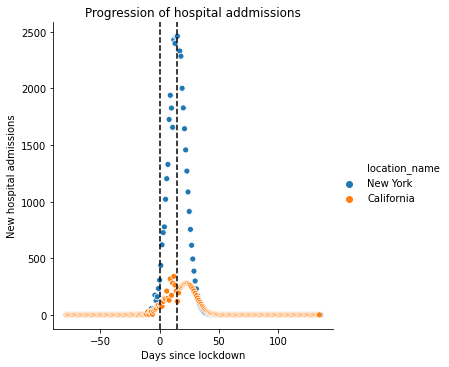

In [0]:
g = sns.relplot(x='days_from_lockdown', y='admis_mean', hue="location_name", data=infections_df)
g.set(xlabel='Days since lockdown', ylabel='New hospital admissions', title='Progression of hospital addmissions')
plt.axvline(0, color='k', linestyle='--')
plt.axvline(15, color='k', linestyle='--')

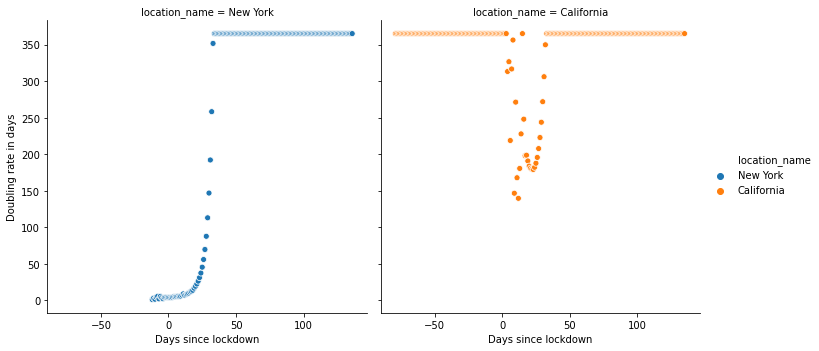

In [0]:
# Would be cool to figure out how to unbind axes in facet plots (Like R's free_y)

g = sns.relplot(x='days_from_lockdown', y='progression', hue="location_name", col="location_name", data=infections_df)
g.set(xlabel='Days since lockdown', ylabel='Doubling rate in days')

# Model

**Approach**

Stupid Model 1. The decision to end a lockdown occurs every 7 days from the initial order. The average rate of growth in the infection across the week is considered. As the rate of infection growth approaches 0, the likelihood of suspending the lockdown increases.

Conditions to consider adding:

* deaths (relative to population)
* deaths (realtive to infected)
* ratio of recovery to newly infected
* % of population has been tested > threshold
* complex priors over dates (1st and 15th of month more likely. Perhaps Holiday's)?
* depletion of susceptible stock 1 - (Infected + Recovered + Deaths) / population > threshold 

Ad-Hoc High-level feature spit-balling:
* Government Market Orientation 
* Government Goal --- Signaling Action | Spread Mitigation  

Model

In [0]:

def model_coarse(area: Area, data: pd.core.frame.DataFrame):
  # make sure reasonable things were passed in
  if not "location_name" in data:
    print(f'The data does not have the expected structure')
    raise Exception("bad data")
  elif not area.get("data_key") in data["location_name"].values:
    print(f'There is currently no infection data for {area["data_key"]}')
    raise Exception("no data")
  elif not area.get("start"):
        print(f'There is currently no lockdown for {area["data_key"]}')
        raise Exception("no lockdown")
      
  area_data = data.loc[data["location_name"] == area.get("data_key")]
  lockdown_duration = 0
  last_weeks_spread_rate = 100
  while True:
    if (max(area_data['days_from_lockdown']) >= lockdown_duration): # keep using las infection_spread_rate if we run out of data (hack for current data)
      infection_spread_rate = np.mean(area_data.loc[(area_data['days_from_lockdown'] >= lockdown_duration) &
                                                    (area_data['days_from_lockdown'] < lockdown_duration + 7), 'progression'])
    stop_quarantine = ergo.flip(scipy.stats.logistic.pdf(infection_spread_rate, scale = .5) +
                                    scipy.stats.logistic.pdf(last_weeks_spread_rate, scale = .5)) 
    lockdown_duration += 7
    last_weeks_spread_rate = infection_spread_rate 
    if(stop_quarantine):
        break


  ergo.tag(torch.Tensor([lockdown_duration]), area.get("data_key"))

In [0]:
def model(area: Area, data: pd.core.frame.DataFrame):
  # make sure reasonable things were passed in
  if not "location_name" in data:
    print(f'The data does not have the expected structure')
    raise Exception("bad data")
  elif not area.get("data_key") in data["location_name"].values:
    print(f'There is currently no infection data for {area["data_key"]}')
    raise Exception("no data")
  elif not area.get("start"):
        print(f'There is currently no lockdown for {area["data_key"]}')
        raise Exception("no lockdown")
      
  area_data = data.loc[data["location_name"] == area.get("data_key")]
  lockdown_duration = 0
  last_weeks_spread_rate = 100
  while True:
    lockdown_duration += 1
    if (max(area_data['days_from_lockdown']) >= lockdown_duration): # keep using las infection_spread_rate if we run out of data (hack for current data)
      infection_spread_rate = np.mean(area_data.loc[(area_data['days_from_lockdown'] > lockdown_duration - 14 ) &
                                                    (area_data['days_from_lockdown'] <= lockdown_duration), 'admis_mean'])
    stop_quarantine = ergo.flip(scipy.stats.logistic.pdf(infection_spread_rate, scale = .5))
    last_weeks_spread_rate = infection_spread_rate 
    if(stop_quarantine):
        break


  ergo.tag(torch.Tensor([lockdown_duration]), area.get("data_key"))

Run Model

In [0]:
samples = pd.DataFrame() #unconditioned :/ 


# This would run it for all questions
#for question in questions:
#  samples[question.name] = ergo.run(lambda: model(get_assumptions(question), infections_df), num_samples=10000).iloc[:,0]

# Let's just look at NY for the moment 
samples[questions[0].name] = ergo.run(lambda: model(get_assumptions(questions[0]), infections_df), num_samples=5000).iloc[:,0]

100%|██████████| 5000/5000 [05:57<00:00, 13.98it/s]


We calculated the model in terms of duration in days, let's get that in dates and get it in the question-normalized form


In [0]:
for question in questions:
  if question.name in samples:
    start_date = get_assumptions(question)["start"]
    samples[question.name + ' days'] = samples[question.name]
    samples[question.name + ' date'] = samples[question.name].apply(lambda x: start_date.add(days=x))
    samples[question.name] =  question.normalize_dates(samples[question.name + ' date'])


<class 'pandas.core.series.Series'>


# Evaluate Model


Histogram Day-Space

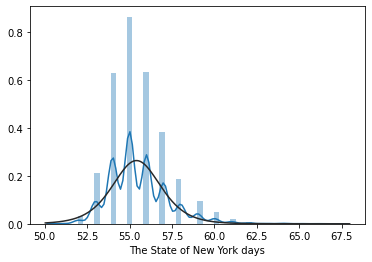

In [0]:
sns.distplot(samples[questions[0].name + ' days'], fit = scipy.stats.logistic)

Histogram Normalized

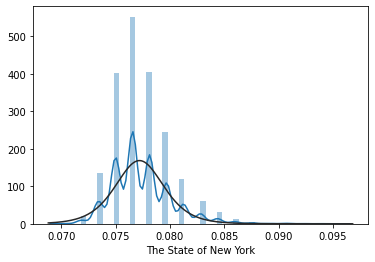

In [0]:
sns.distplot(samples[questions[0].name], fit = scipy.stats.logistic)

Summary Stats

In [0]:
samples.describe()

,The State of New York,The State of New Yorknormalized
count,5000.000000,5000.000000
mean,54.549200,0.075858
std,1.721561,0.002690
min,50.000000,0.068750
25%,53.000000,0.073438
50%,54.000000,0.075000
75%,55.000000,0.076563
max,66.000000,0.093750


# Submit Predictions

## Submit from sample

In [0]:
def submit_all():
  for question in questions:
    if question.name in samples:
      try:
        params = question.submit_from_samples(samples[question.name])
        print(f"Submitted Logistic{params} for {question.name}")
        print(f"https://pandemic.metaculus.com{question.page_url}")
      except requests.exceptions.HTTPError as e:
        print(f"Couldn't make prediction for {question.name} -- maybe this question is now closed? See error below.")
        print(e)
    else:
      print(f"No predictions for {question.name}")

Submit it!

In [0]:
submit_all()

Submitted Logistic<Response [202]> for The State of New York
https://pandemic.metaculus.com/questions/3952/when-will-the-current-total-lockdown-in-the-state-of-new-york-be-lifted-or-reduced-in-intensity/
No predictions for The State of California


# Fit Model

Metaculus accepts submissions in terms of a mixture of up to 5 logistic distributions. Take the samples from the generative model and infer the best logistic mixture

In [0]:
def fit_and_plot(samples, num_components):
  learned_mixture_params = logistic.fit_mixture(samples, num_components=num_components)
  def sample_logistic_mixture(mixture_params):
    i = ergo.categorical(torch.Tensor(mixture_params.probs))
    component_params = mixture_params.components[i]
    return np.random.logistic(loc=component_params.loc, scale=component_params.scale)
  learned_samples = np.array([sample_logistic_mixture(learned_mixture_params) for _ in range(5000)])
  ax = sns.distplot(samples, label="Target")
  sns.distplot(learned_samples, label="Fitted")
  plt.legend()
  ax.set(xlabel='Sample value', ylabel='Density')
  return learned_mixture_params

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
100%|██████████| 5000/5000 [00:18<00:00, 273.18it/s]


LogisticMixtureParams(components=[LogisticParams(loc=0.5116737, scale=0.4183891), LogisticParams(loc=0.08080669, scale=0.003948114)], probs=[0.2057126, 0.79428744])

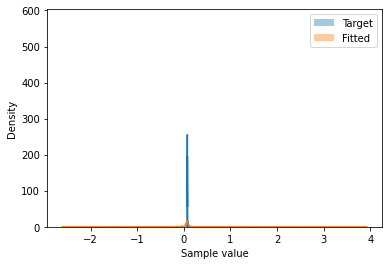

In [0]:
fit_and_plot(samples.iloc[:,0].values, 2)